# 导入

In [ ]:
# 将文件挂载到服务器
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import networkx as nx
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from numpy.random import rand
from scipy.io import loadmat
from keras.models import load_model
import time

# trainingData

In [ ]:
class trainingData:
    entry_points = None
    destination = None
    FN = None
    FP = None
    beta = None
    IFG = None
    SS = None
    Action_set_DIFT = None
    Action_set_APT = None
    intermediate_destinations = None


    def __init__(self,entry_points,destination,intermediate_destinations,FN,FP,beta,IFG,SS,Action_set_DIFT,Action_set_APT):
        self.entry_points = entry_points
        self.destination = destination
        self.FN = FN
        self.FP = FP
        self.beta = beta
        self.IFG = IFG
        self.SS = SS
        self.Action_set_DIFT = Action_set_DIFT
        self.Action_set_APT = Action_set_APT
        self.intermediate_destinations = intermediate_destinations

    def Generate_Training_Data(self,training_sets, pecent_stochastic_DIFT, pecent_stochastic_APT):
        IFG_length = len(self.IFG)
        SS_length = len(self.SS)

        DIFT_Policies_Data = []
        APT_Policies_Data = []

        V = np.zeros((training_sets, SS_length))
        V[:, IFG_length + 1] = self.beta
        V[:, IFG_length + 3] = self.beta

        Input_vector_NN = [] #Input to the NN (i.e., DIFT policy + APT policy corresponding to each time ts)
        Output_Data_NN = [] #Output of the NN (i.e., Value vector)


        for ts in range(0,training_sets):
            #seed(1)

            policy_type_DIFT = 0 #Type of DIFT policy :- Type 0: Deterministic, Type 1:Stochastic
            uniform_var_DIFT = np.random.uniform(0,1,1)
            if pecent_stochastic_DIFT >= uniform_var_DIFT*100:
                policy_type_DIFT = 1

            #Generating random policies for DIFT
            DIFT_Policy = []

            if policy_type_DIFT == 0:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_DIFT[ii]) != 1:
                        random_vec_DIFT = np.zeros(len(self.Action_set_DIFT[ii]))
                        DIFT_action = np.random.randint(len(self.Action_set_DIFT[ii]), size=1)
                        random_vec_DIFT[DIFT_action] = 1
                        DIFT_Policy.append((random_vec_DIFT).tolist())
                    else:
                        DIFT_Policy.append([1])
            else:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_DIFT[ii]) != 1:
                        random_vec_DIFT = abs(rand(len(self.Action_set_DIFT[ii])))
                        DIFT_Policy.append((random_vec_DIFT / sum(random_vec_DIFT)).tolist())
                    else:
                        DIFT_Policy.append([1])


            policy_type_APT = 0 #Type of APT policy :- Type 0: Deterministic, Type 1:Stochastic
            uniform_var_APT = np.random.uniform(0,1,1)
            if pecent_stochastic_APT >= uniform_var_APT*100:
                policy_type_APT = 1


            # Generating random policies for APT
            APT_Policy = []

            if policy_type_APT == 0:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_APT[ii]) != 1:
                        random_vec_APT = np.zeros(len(self.Action_set_APT[ii]))
                        APT_action = np.random.randint(len(self.Action_set_APT[ii]), size=1)
                        random_vec_APT[APT_action] = 1
                        APT_Policy.append((random_vec_APT).tolist())
                    else:
                        APT_Policy.append([1])
            else:
                for ii in range(0, IFG_length+1): #IFG states + Virtual state
                    if len(self.Action_set_APT[ii]) != 1:
                        random_vec_APT = abs(rand(len(self.Action_set_APT[ii])))
                        APT_Policy.append((random_vec_APT / sum(random_vec_APT)).tolist())
                    else:
                        APT_Policy.append([1])


            #Collect policy data into list
            DIFT_Policies_Data.append(DIFT_Policy)
            APT_Policies_Data.append(APT_Policy)

            #Evaluating the valuye functions (Dynamic programing:Back propagation approach to evaluate value function)

            #Convert IFG transition matrix to nx.DiGraph format
            IFG_graph = nx.DiGraph()
            for ii in range(IFG_length):
                for jj in range(IFG_length):
                    if self.IFG[ii, jj] == 1:
                        IFG_graph.add_edge(ii, jj)
            #Topological order for dynamic program (Only consider IFG node related states)
            TP_Order = list(reversed(list(nx.topological_sort(IFG_graph))))
            #Excluding destination node related states from state space
            SS_To_Visit = TP_Order.copy()
            for ii in range(0,len(TP_Order)):
                dest_flag = TP_Order[ii] in self.destination.tolist()
                inter_dest_flag = TP_Order[ii] in self.intermediate_destinations.tolist()
                if int(dest_flag) == 1 or int(inter_dest_flag) == 1:
                    pop_index = SS_To_Visit.index(TP_Order[ii])
                    SS_To_Visit.pop(pop_index)

            #Calculating the values at all non-absorbing states except at the virtual state
            #V[ts, SS_To_Visit[ii]] = 0
            for ii in range(0,len(SS_To_Visit)):
                for dd in range(0,len(self.Action_set_DIFT[SS_To_Visit[ii]])):
                    for aa in range(0,len(self.Action_set_APT[SS_To_Visit[ii]])):
                        if aa == (len(self.Action_set_APT[SS_To_Visit[ii]]) - 1):  # APT dropout
                            V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + V[ts, IFG_length + 3]*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]  # Next state is \phi
                            # print(t,ii,kk,Q)
                        else:  # APT not dropped out
                            if dd < (len(self.Action_set_DIFT[SS_To_Visit[ii]]) - 1):  # DIFT trap
                                if dd == aa:  # Trap performed at the APT's state
                                    # Two cases due to False negatives
                                    V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + ((1 - self.FN[self.Action_set_DIFT[SS_To_Visit[ii]][dd]])*V[ts, IFG_length + 1] + self.FN[self.Action_set_DIFT[SS_To_Visit[ii]][dd]]*V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]])*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]
                                    # Next state is APT's transition action +   \tau_A
                                else:  # unsuccessful trap due to different place of trapping
                                    # Two cases due to False Positives
                                    V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + ((1 - self.FP[self.Action_set_DIFT[SS_To_Visit[ii]][dd]])*V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]] + self.FP[self.Action_set_DIFT[SS_To_Visit[ii]][dd]]*V[ts, IFG_length + 2])*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]
                                    # Next state is APT's transition action +   \tau_B
                            else:  # DIFT does not trap
                                V[ts, SS_To_Visit[ii]] = V[ts, SS_To_Visit[ii]] + V[ts, self.Action_set_APT[SS_To_Visit[ii]][aa]]*DIFT_Policy[SS_To_Visit[ii]][dd]*APT_Policy[SS_To_Visit[ii]][aa]  # Next state is APT's transition action


            #Calculating value at the virtual state
            for aa in range(0, len(self.Action_set_APT[IFG_length])):
                V[ts, IFG_length] = V[ts, IFG_length] + V[ts, self.Action_set_APT[IFG_length][aa]]*APT_Policy[IFG_length][aa] #Next state depends on the APT's transition

            #Setting values at the intermediate states
            for ii in self.intermediate_destinations.tolist():
                neighbor = np.nonzero(self.IFG[ii, :])
                V[ts, ii] = V[ts, neighbor[0]]

        #Reshaping the Input vectors (DIFT + APT policy)

            tmp_input_vec = []
            for ii in range(0, len(DIFT_Policy) + len(APT_Policy)):
                if ii < len(DIFT_Policy):
                    num_actions_DIFT = len(DIFT_Policy[ii])
                    if num_actions_DIFT == 0:
                        tmp_input_vec = tmp_input_vec + [1]
                    else:
                        for kk in range(0,num_actions_DIFT):
                            tmp_input_vec = tmp_input_vec + [DIFT_Policy[ii][kk]]
                else:
                    #Shift ii variable
                    ii = ii - len(DIFT_Policy)
                    num_actions_APT = len(APT_Policy[ii])
                    if num_actions_APT == 0:
                        tmp_input_vec = tmp_input_vec + [1]
                    else:
                        for kk in range(0,num_actions_APT):
                            tmp_input_vec = tmp_input_vec + [APT_Policy[ii][kk]]

            Input_vector_NN.append(tmp_input_vec)

        V = V.tolist()
        Input_Output_Data = []
        Input_Output_Data.append(Input_vector_NN)
        Input_Output_Data.append(V)

        return Input_Output_Data


# NN_model

In [ ]:
def Train_NN_model():

    save_flag = 0
    #Divide dataset into train, test and validation
    num_vali = int(TD_len*0.1)
    Policy_vali = Policy[0:num_vali]
    Policy_test = Policy[num_vali:2*num_vali]
    Policy_train = Policy[2*num_vali:]

    Value_vali = -(Value[0:num_vali])
    Value_test = -(Value[num_vali:2*num_vali])
    Value_train = -(Value[2*num_vali:])

    #Define Neural Network
    model = Sequential()
    model.add(Dense(1000, input_dim=len(Policy_train[0]), activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(len(Value_train[0])))

    # model_name=model.save('NN_trained.keras')

    # model_name = 'NN_trained.h5'
    # 修改后缀名
    model_name = 'NN_trained.keras'
    #Define parameters

    # 调参：batch_size = 128
    batch_size = 128
    # 调参：num_training_epoch = 100
    num_training_epoch = 200
    #num_training_epoch = 1
    learning_rate = 2e-1
    #learning_rate_decay = learning_rate/(num_training_epoch)#1e-6
    learning_rate_decay = 1e-5
    target_mae = 500 #precision in mean absolute error
    epoch = 0 # 不是num_training_epoch

    #Define Stochastic Gradient Descent class
    # lr改成了learning_rate并且删除了decay=learning_rate_decay
    # 修改优化器   adam = Adam(learning_rate=learning_rate)

    sgd = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

    #Compute MSE (mean square error)  for trainig, validation and test data
    # 添加参数verbose = 0
    _, train_mae = model.evaluate(Policy_train, Value_train, verbose=0)
    _, vali_mae = model.evaluate(Policy_vali, Value_vali, verbose=0)
    _, test_mae = model.evaluate(Policy_test, Value_test, verbose=0)

    #print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))

    for epoch in range(num_training_epoch):

        #t1 = time.time()

        ##########################################################

        if epoch % 20 == 0:
            learning_rate /= 2
        # lr改成learning_rate 删除decay=learning_rate_decay
        # 把SGD换成Adam优化器进行优化  adam = Adam(learning_rate=learning_rate)

            sgd = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
            model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

        ##########################################################

        #Fit model
        model.fit(Policy_train, Value_train, batch_size=batch_size, epochs=1, verbose=0)

        ##########################################################
        #把verbose改为0
        _, train_mae = model.evaluate(Policy_train, Value_train, verbose=0)
        _, vali_mae = model.evaluate(Policy_vali, Value_vali, verbose=0)
        _, test_mae = model.evaluate(Policy_test, Value_test, verbose=0)

        ##########################################################
        print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))

        if np.round(1000*vali_mae) <= target_mae:
            model.save(model_name)
            target_mae = np.round(1000*vali_mae)
            print('Saved!')
            save_flag = 1
            #print("epoch: " + str(epoch) + ", train mae: " + str(np.round(1000*train_mae)) + ", vali mae: " + str(np.round(1000*vali_mae)) + ", test mae: " + str(np.round(1000*test_mae)))
    if save_flag == 0:
        model.save(model_name)
        print('Saved-Not a good approximation!')

# Stage_Game_solver

In [ ]:
def Stage_Game_solver(current_state,Q_est,V,estimate = False):
    # Policy for DIFT (optimization variable in LP)
    DIFT_Policy_current_state = np.zeros((len(Action_set_DIFT[current_state]))).tolist()

    # Define Linear Program
    # Variable structure [p(s,d1), ..., p(s,dN), V(s)]

    # Objective function
    obj = np.zeros(len(DIFT_Policy_current_state)).tolist()
    obj.extend([-1])  # last entry corresponding to value function at state current_state

    # Linear equality constraints (Total one)
    # Sum of DIFT's defense policy at each state current_state is one
    lhs_eq = np.ones((1, len(DIFT_Policy_current_state) + 1)).tolist()  # +1 to represent V(s)
    lhs_eq[0][-1] = 0  # last entry is "0" (no V(s) involved)
    rhs_eq = [1]

    # Linear inequality constraints (Total = # actions of DIFT at state current_state + # of actions of APT at state current_state
    # Each entry is poliy of DIFT must be > 0 + For each APT's action V(s) <= \sum_{d} Q(s,d,a)pD(s,d)
    #print(len(Action_set_DIFT[current_state]),len(Action_set_APT[current_state]))
    len_lhs_ineq = len(Action_set_DIFT[current_state]) + len(Action_set_APT[current_state])
    lhs_ineq = np.zeros((len_lhs_ineq, len(DIFT_Policy_current_state) + 1)).tolist()
    # print(current_state, lhs_ineq)
    #Initializing exact Q values (in a matrix where rows: DIFT's actions, columns: APT's actions)
    Q_values_exact = np.zeros((len(Action_set_DIFT[current_state]), len(Action_set_APT[current_state])))
    for jj in range(0, len_lhs_ineq):
        if jj < len(Action_set_DIFT[current_state]):  # constraint on the probability
            # lhs_ineq[jj] = np.zeros(len(DIFT_Policy_current_state)+1).tolist()
            lhs_ineq[jj][jj] = -1

        else:  # constraints on Q and DIFT's policy
            lhs_ineq[jj][-1] = 1  # V(s) position
            kk = jj - len(Action_set_DIFT[current_state])  # APT action
            for ll in range(0, len(Action_set_DIFT[current_state])):
                if int(estimate) == 0: #Calculating exact Q values using the knowledge on FPs and FNs
                    Q = 0
                    if kk == (len(Action_set_APT[current_state]) - 1):  # APT dropout
                        Q = V[IFG_length + 3]  # Next state is \phi
                        # print(t,ii,kk,Q)
                    else:  # APT not dropped out
                        if ll < (len(Action_set_DIFT[current_state]) - 1):  # DIFT trap
                            if kk == ll:  # Trap performed at the APT's state
                                # Two cases due to False negatives
                                Q = (1 - FN[Action_set_DIFT[current_state][ll]]) * V[IFG_length + 1] + FN[
                                    Action_set_DIFT[current_state][ll]] * V[Action_set_APT[current_state][kk]]
                                # Next state is APT's transition action +   \tau_A
                            else:  # unsuccessful trap due to different place of trapping
                                # Two cases due to False Positives
                                Q = (1 - FP[Action_set_DIFT[current_state][ll]]) * V[Action_set_APT[current_state][kk]] + FP[
                                    Action_set_DIFT[current_state][ll]] * V[IFG_length + 2]
                                # Next state is APT's transition action +   \tau_B
                        else:  # DIFT does not trap
                            Q = V[Action_set_APT[current_state][kk]]  # Next state is APT's transition action

                    lhs_ineq[jj][ll] = -Q
                    Q_values_exact[ll][kk] = Q

                else:#Using Q values estimated using NN model
                    Q = 0
                    if kk == (len(Action_set_APT[current_state]) - 1):  # APT dropout
                        Q = V[IFG_length + 3]  # Next state is \phi
                        Q_est[ll][kk] = -Q
                    else:  # APT not dropped out
                        if ll < (len(Action_set_DIFT[current_state]) - 1):  # DIFT trap
                            if kk == ll:  # Trap performed at the APT's state
                                # use estimated Q values since FN unknown
                                Q = -Q_est[ll][kk]
                                # Next state is APT's transition action +   \tau_A
                            else:  # unsuccessful trap due to different place of trapping
                                # use estimated Q values since FP unknown
                                Q = -Q_est[ll][kk]
                                # Next state is APT's transition action +   \tau_B
                        else:  # DIFT does not trap
                            Q = V[Action_set_APT[current_state][kk]]  # Next state is APT's transition action
                            Q_est[ll][kk] = -Q
                    lhs_ineq[jj][ll] = -Q


    rhs_ineq = np.zeros(len_lhs_ineq).tolist()

    # Solve LP
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq,
                  method="revised simplex")
    DIFT_Policy_tmp = opt.x[0:-1]
    # Update DIFT's Policy
    DIFT_Policy_current_state = DIFT_Policy_tmp.tolist()
    # Update the value function
    V_current_state = opt.x[-1]

    #Finding APT's NE policy
    if int(estimate) == 0: #Based on exact Q values
        payoff_vector_APT = (Q_values_exact.T).dot(DIFT_Policy_tmp.T)
    else: #Based on estimated Q values
        payoff_vector_APT = -(Q_est.T).dot(DIFT_Policy_tmp.T)

    APT_action_ID = (payoff_vector_APT.tolist()).index(min(payoff_vector_APT))
    APT_Policy_tmp = np.zeros(len(Action_set_APT[current_state]))
    APT_Policy_tmp[APT_action_ID] = 1
    APT_Policy_current_state = APT_Policy_tmp.tolist()


    #Save output data (NE policies and NE value corresponding to the current state)
    Policy_Values = []
    Policy_Values.append(DIFT_Policy_current_state)
    Policy_Values.append(APT_Policy_current_state)
    Policy_Values.append(V_current_state)

    return Policy_Values

# value_iteration_main

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
def value_iteration_main(exact_apprx_flag):

    #Initializing the value vector of the game
    V = np.zeros(SS_length)
    V[IFG_length + 1] = beta
    V[IFG_length + 3] = beta

    #Random stochastic policies for DIFT and APT
    TrainingDataObj = trainingData(entry_points, destination, intermediate_destinations, FN, FP, beta, IFG, SS, Action_set_DIFT, Action_set_APT)
    pecent_stochastic_DIFT = 40 #Specify percentage of stochastic policies generated for DIFT
    pecent_stochastic_APT = 0 #Specify percentage of stochastic policies generated for APT
    Training_Data_sample = TrainingDataObj.Generate_Training_Data(1,pecent_stochastic_DIFT,pecent_stochastic_APT)
    Input_vector = np.copy(Training_Data_sample[0])

    #Solving stage games using NN predicttions of "Q" values
    for ii in range(0,len(SS_To_Visit)):

        current_state = SS_To_Visit[ii]

        #Solving the stage game using LP with exact Q values if estimate = False
        if exact_apprx_flag == 1:
            Policy_Values = Stage_Game_solver(current_state,[],V,estimate = False)
        elif exact_apprx_flag == 0:
            num_DIFT_actions = len(Action_set_DIFT[current_state])
            num_APT_actions = len(Action_set_APT[current_state])
            Q_est = np.zeros((num_DIFT_actions, num_APT_actions))#Q table for each state, rows: DIFT's actions, Columns:APT's actions

            #Estimating Q values using trained NN model
            for dd in range(0,num_DIFT_actions):
                for aa in range(0,num_APT_actions):
                    #Constructing input vector for NN  to predict corresponding Q values at the "current state"
                    #Deterministic policies at the current state
                    PdPa_current_state = np.zeros((num_DIFT_actions+num_APT_actions))
                    PdPa_current_state[dd] = 1
                    PdPa_current_state[aa+num_DIFT_actions] = 1
                    PdPa_current_state.tolist()

                    #Identifying the locations in Input_vector where PdPa_current_state needs to ve substituted
                    start_ptr_DIFT_policy = 0
                    end_ptr_DIFT_policy = 0
                    start_ptr_APT_policy = 0
                    end_ptr_APT_policy = 0
                    Total_Actions_DIFT = 0
                    for ss in range(0,SS_length-3):
                        if len(Action_set_DIFT[ss]) == 0:
                            Total_Actions_DIFT = Total_Actions_DIFT + 1
                        else:
                            Total_Actions_DIFT = Total_Actions_DIFT + len(Action_set_DIFT[ss])

                    for ss in range(0,SS_length-3):
                        if ss == current_state:
                            break

                        if len(Action_set_DIFT[ss]) == 0:
                            start_ptr_DIFT_policy = start_ptr_DIFT_policy + 1
                        else:
                            start_ptr_DIFT_policy = start_ptr_DIFT_policy + len(Action_set_DIFT[ss])

                        if len(Action_set_APT[ss]) == 0:
                            start_ptr_APT_policy = start_ptr_APT_policy + 1
                        else:
                            start_ptr_APT_policy = start_ptr_APT_policy + len(Action_set_APT[ss])

                    end_ptr_DIFT_policy = start_ptr_DIFT_policy + len(Action_set_DIFT[current_state])
                    start_ptr_APT_policy = start_ptr_APT_policy + Total_Actions_DIFT
                    end_ptr_APT_policy = start_ptr_APT_policy + len(Action_set_APT[current_state])

                    #Replacing places in random policy input with deterministic policies corresponding to the current state
                    Input_vector[0][start_ptr_DIFT_policy:end_ptr_DIFT_policy] = PdPa_current_state[0:num_DIFT_actions]
                    Input_vector[0][start_ptr_APT_policy:end_ptr_APT_policy] = PdPa_current_state[num_DIFT_actions:]

                    #Estimating Q values using NN trained model
                    Value_predict = NN_model.predict(Input_vector,verbose=0)
                    Q_est[dd][aa] = Value_predict[0][current_state]

            #Solving the stage game using LP with estimated Q values if estimate = True
            Policy_Values = Stage_Game_solver(current_state,Q_est,V,estimate = True)
            Input_vector[0][start_ptr_DIFT_policy:end_ptr_DIFT_policy] = Policy_Values[0]
            Input_vector[0][start_ptr_APT_policy:end_ptr_APT_policy] = Policy_Values[1]

        V[current_state] = Policy_Values[2]



    # Virtual state
    tmp_s0_value = beta
    for nn in range(0, len(entry_points)):
        if tmp_s0_value > V[entry_points[nn]]:
            tmp_s0_value = V[entry_points[nn]]

    V[IFG_length] = tmp_s0_value

    #Setting values at the intermediate destination related states
    for ii in intermediate_destinations.tolist():
        neighbor = np.nonzero(IFG[ii, :])
        V[ii] = V[neighbor[0]]

    return V


# parameter

In [ ]:
# Define game related parameters here (e.g., IFG, entrypoints, destinations, rewards, etc...)

#Load Ransomware attack state space (without s0, \Tau_A, \Tau_B and \Phi states)
import scipy.io

# 修改文件路径
IFG_Data = scipy.io.loadmat('/content/drive/MyDrive/Solstice/Ransomeware_Data.mat')
IFG = IFG_Data['state_transition_mat']

#Define set of states corresponding to entrypoint(s) of the attack
entry_points = np.array([0, 6])
#Define set of states corresponding to final destination(s) of the attack
destination = np.array([16])
#Define set of states corresponding to intermediate destinaton(s) of the attack
intermediate_destinations = np.array([2,9])
#Define False negatives asscoiated with the states
FN = [0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1, 0.1, 0.2, 0.05, 0.1, 0.1]
#Define False positives asscoiated with the states
FP = [0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1, 0.2, 0.1, 0.1, 0.05, 0.1]

#Define reward value (beta)
beta = 50
Tdata_len = np.array([1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250]).tolist()

IFG_length = len(IFG)
IFG_Graph = nx.from_numpy_array(np.array(IFG))

IFG_graph = nx.DiGraph()
for ii in range(IFG_length):
    for jj in range(IFG_length):
        if IFG[ii, jj] == 1:
            IFG_graph.add_edge(ii, jj)



SS_length = IFG_length + 4  # s0, tau_A, tau_B, tau_C
SS = np.zeros((SS_length, SS_length))

for ii in range(SS_length - 1):
    if ii <= (IFG_length - 1) and ii != destination[0]:
        SS[ii, IFG_length + 1:IFG_length + 4] = np.ones((1, 3), dtype=int)
    if ii == IFG_length:
        SS[ii, entry_points] = 1
    for jj in range(SS_length - 1):
        if ii <= (IFG_length - 1) and jj <= (IFG_length - 1):
            SS[ii, jj] = IFG[ii, jj]

SS_graph = nx.DiGraph()
for ii in range(SS_length):
    for jj in range(SS_length):
        if SS[ii, jj] == 1:
            SS_graph.add_edge(ii, jj)

# nx.draw_networkx(IFG_graph, with_labels=True)
# plt.show()


# Action set of players at IFG nondestination nodes and policy of defender
# Action sets
Action_set_DIFT = []
Action_set_APT = []
neighbors = []

for ii in range(0, IFG_length + 1):
    if (ii == IFG_length):  # Action sets at the virtual state
        Action_set_DIFT.append([-2])  #action of DIFT ---> pseudo action
        Action_set_APT.append(entry_points.tolist())
    elif (ii in destination) or (ii in intermediate_destinations):
        Action_set_DIFT.append([-2]) #action of DIFT ---> pseudo action
        Action_set_APT.append([-2]) #action of APT ---> pseudo action
    else:
        neighbors = np.nonzero(IFG[ii, :])
        Action_set_DIFT.append(neighbors[0])
        Action_set_APT.append(neighbors[0])
        x = Action_set_DIFT[ii].tolist()
        x.extend([-1])  # -1 action of DIFT ---> performing a security analysis
        y = Action_set_APT[ii].tolist()
        y.extend([-1])  # -1 action of APT ---> quitting thee attack
        Action_set_DIFT[ii] = x
        Action_set_APT[ii] = y



#Topological order for solving stage games (Only consider IFG node related states)
TP_Order = list(reversed(list(nx.topological_sort(IFG_graph))))
SS_To_Visit = TP_Order.copy() #List will keep only non-destination related IFG states
for ii in range(0,len(TP_Order)):
    dest_flag = TP_Order[ii] in destination.tolist()
    inter_dest_flag = TP_Order[ii] in intermediate_destinations.tolist()
    if int(dest_flag) == 1 or int(inter_dest_flag) == 1:
        pop_index = SS_To_Visit.index(TP_Order[ii])
        SS_To_Visit.pop(pop_index)



In [ ]:
from keras.models import load_model
Exact_data = []
Estimated_data = []
exact_counter = 0
print(Tdata_len)
#print(len(Tdata_len))
#for TDlen_counter in range(0,len(Tdata_len)):
for TDlen_counter in range(0,len(Tdata_len)):

    TD_len = Tdata_len[TDlen_counter]*1000
    print('TD length:',TD_len)
    Values_Exact = value_iteration_main(exact_apprx_flag = 1)
    Exact_data.append(Values_Exact)

    Estimated_data_tmp = []
    #Generating training data
    TrainingDataObj = trainingData(entry_points, destination, intermediate_destinations, FN, FP, beta, IFG, SS, Action_set_DIFT, Action_set_APT)
    pecent_stochastic_DIFT = 40 #Specify percentage of stochastic policies generated for DIFT
    pecent_stochastic_APT = 0 #Specify percentage of stochastic policies generated for APT
    Input_Output_Data = TrainingDataObj.Generate_Training_Data(TD_len,pecent_stochastic_DIFT,pecent_stochastic_APT) # '0': Input Data for NN ; '1': Output data for NN
    np.savez('Data.npz', PdPa=Input_Output_Data[0], V=Input_Output_Data[1])
    data = np.load('Data.npz')
    Policy = data['PdPa']
    Value = data['V']
    #Training NN
    Train_NN_model()
    for experiments in range(0,1):
      #  model.save('NN_trained.keras')

        # NN_model = load_model('NN_trained.h5')
        # NN_model.save('NN_converted.keras')
        # NN_model = load_model('NN_converted.keras')
        NN_model = load_model('NN_trained.keras')
        Values_Approximated = value_iteration_main(exact_apprx_flag = 0)
        Estimated_data_tmp.append(Values_Approximated)

    Estimated_data.append(Estimated_data_tmp)
    print('Exact:',Exact_data[exact_counter])

    # print('Estimated sample:',Estimated_data[exact_counter][4])
    exact_counter = exact_counter + 1

np.savez('Plot_Data_Tdata2.npz', Exact_data = Exact_data, Estimated_data = Estimated_data)

[1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250]
TD length: 1000


<ipython-input-5-9031a0233901>:82: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq,


流式输出内容被截断，只能显示最后 5000 行内容。
epoch: 195, train mae: 948.0, vali mae: 1176.0, test mae: 1245.0
epoch: 196, train mae: 948.0, vali mae: 1176.0, test mae: 1245.0
epoch: 197, train mae: 948.0, vali mae: 1176.0, test mae: 1245.0
epoch: 198, train mae: 948.0, vali mae: 1176.0, test mae: 1245.0
epoch: 199, train mae: 948.0, vali mae: 1176.0, test mae: 1245.0
Saved-Not a good approximation!
Exact: [48.63636364 43.18181818 40.90909091 47.5        47.5        47.5
 48.63636364 40.90909091 45.         36.98113208 45.         45.
 45.         45.         36.98113208 40.          0.         49.
 49.         49.         48.63636364 50.          0.         50.        ]
TD length: 6000
epoch: 0, train mae: 12517.0, vali mae: 12903.0, test mae: 12630.0
epoch: 1, train mae: 9871.0, vali mae: 10192.0, test mae: 10017.0
epoch: 2, train mae: 9251.0, vali mae: 9640.0, test mae: 9401.0
epoch: 3, train mae: 9042.0, vali mae: 9437.0, test mae: 9192.0
epoch: 4, train mae: 8896.0, vali mae: 9300.0, test mae: 9045.

In [ ]:
print(len(Tdata_len))

20


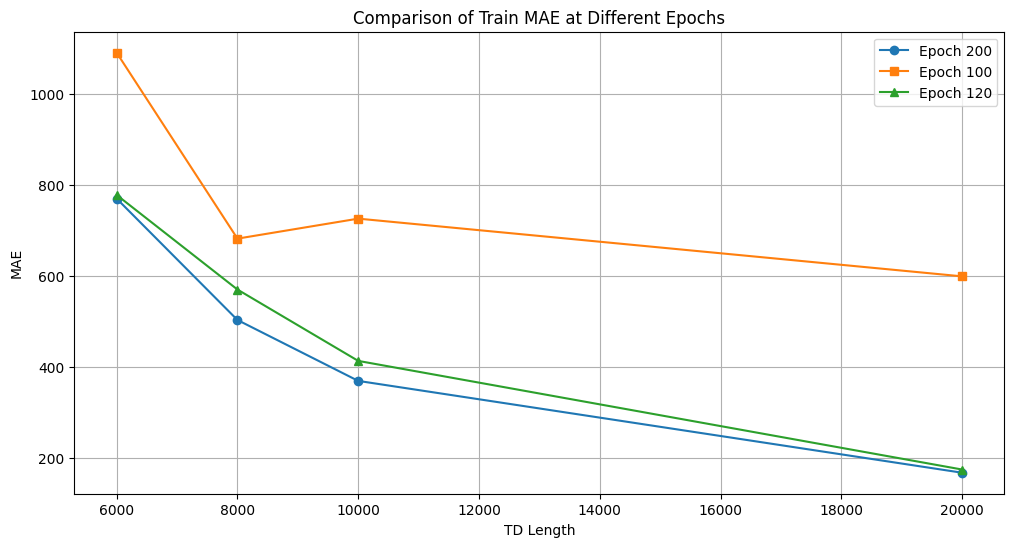

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated data with values and the requested chart title
data_final = {
    'TD_length': [6000, 8000, 10000, 20000],
    'epoch_200': [770, 503, 369, 167],
    'epoch_100': [1091, 682, 726, 599],
    'epoch_120': [778, 570, 413, 174]
}

# Convert the updated data to a pandas DataFrame
df_final = pd.DataFrame(data_final)

# Plotting the comparison as a line chart with TD_length on the x-axis and a specific title
plt.figure(figsize=(12, 6))

# Plotting each epoch against TD_length
plt.plot(df_final['TD_length'], df_final['epoch_200'], marker='o', label='Epoch 200')
plt.plot(df_final['TD_length'], df_final['epoch_100'], marker='s', label='Epoch 100')
plt.plot(df_final['TD_length'], df_final['epoch_120'], marker='^', label='Epoch 120')

# Adding details to the plot
plt.xlabel('TD Length')
plt.ylabel('MAE')
plt.title('Comparison of Train MAE at Different Epochs')
plt.legend()
plt.grid(True)

file_path = '/content/sample_data'
plt.savefig(file_path)

plt.show()


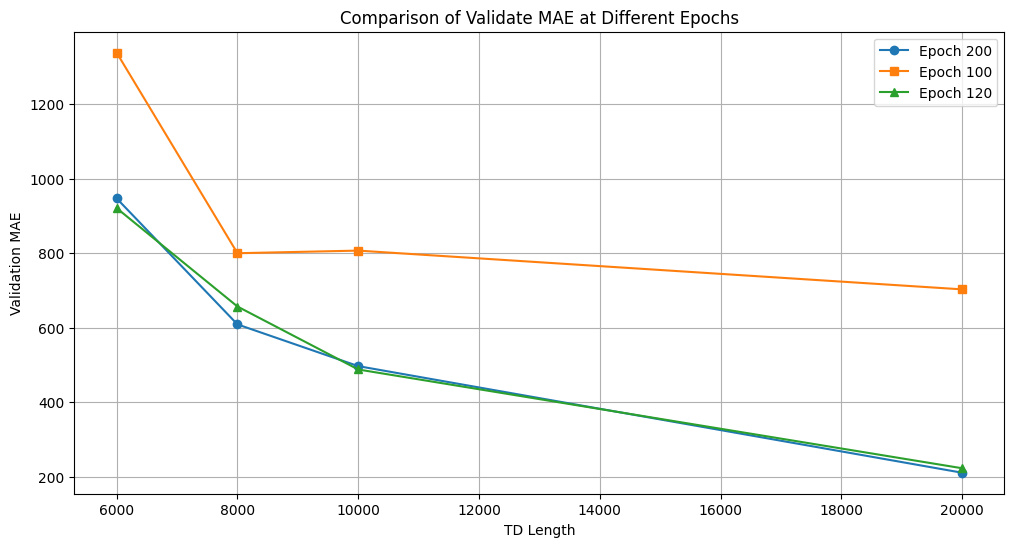

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# New data for validation MAE with the requested chart title
data_validation = {
    'TD_length': [6000, 8000, 10000, 20000],
    'epoch_200': [947, 609, 497, 211],
    'epoch_100': [1338, 800, 807, 703],
    'epoch_120': [921, 657, 488, 223]
}

# Convert the new data to a pandas DataFrame
df_validation = pd.DataFrame(data_validation)

# Plotting the comparison as a line chart with TD_length on the x-axis and a specific title
plt.figure(figsize=(12, 6))

# Plotting each epoch against TD_length for validation MAE
plt.plot(df_validation['TD_length'], df_validation['epoch_200'], marker='o', label='Epoch 200')
plt.plot(df_validation['TD_length'], df_validation['epoch_100'], marker='s', label='Epoch 100')
plt.plot(df_validation['TD_length'], df_validation['epoch_120'], marker='^', label='Epoch 120')

# Adding details to the plot
plt.xlabel('TD Length')
plt.ylabel('Validation MAE')
plt.title('Comparison of Validate MAE at Different Epochs')
plt.legend()
plt.grid(True)

file_path = '/content/sample_data'
plt.savefig(file_path)

plt.show()

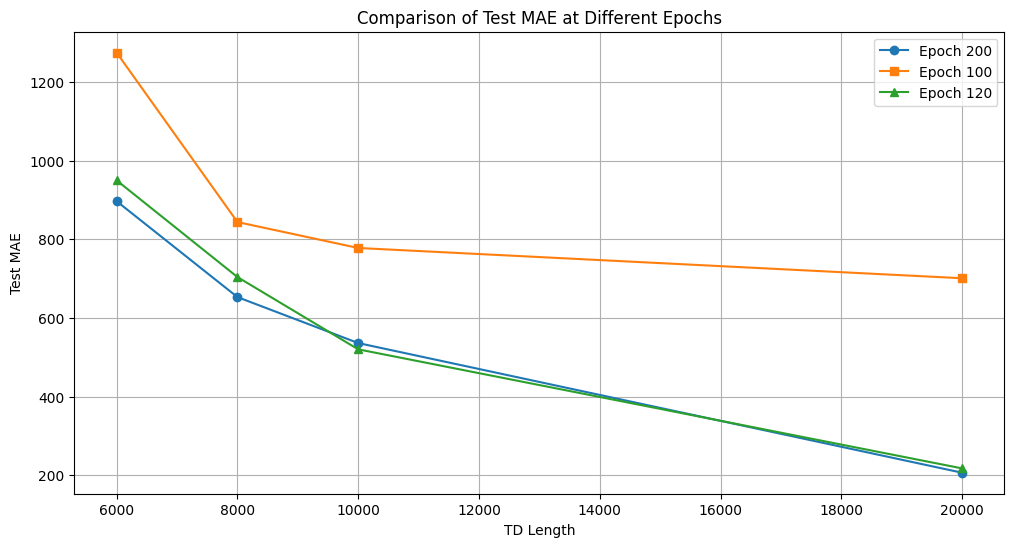

In [ ]:
# Data for test MAE with the new requested chart title
data_test = {
    'TD_length': [6000, 8000, 10000, 20000],
    'epoch_200': [897, 653, 536, 206],
    'epoch_100': [1275, 844, 778, 701],
    'epoch_120': [950, 704, 520, 217]
}

# Convert the new data to a pandas DataFrame
df_test = pd.DataFrame(data_test)

# Plotting the comparison as a line chart with TD_length on the x-axis and a specific title
plt.figure(figsize=(12, 6))

# Plotting each epoch against TD_length for test MAE
plt.plot(df_test['TD_length'], df_test['epoch_200'], marker='o', label='Epoch 200')
plt.plot(df_test['TD_length'], df_test['epoch_100'], marker='s', label='Epoch 100')
plt.plot(df_test['TD_length'], df_test['epoch_120'], marker='^', label='Epoch 120')

# Adding details to the plot
plt.xlabel('TD Length')
plt.ylabel('Test MAE')
plt.title('Comparison of Test MAE at Different Epochs')
plt.legend()
plt.grid(True)


file_path = '/content/sample_data'
plt.savefig(file_path)

plt.show()
